In [3]:
library(here)
library(raster)
library(rgdal)
library(data.table)
library(sp)
library(ggplot2)

In [4]:
path2ssizes<-here("data","sample_sizes.csv")

In [5]:
library(data.table)

In [6]:
crop_names<-c("rice","millet","buckwheat","wheat","barley")

In [7]:
suitability<-read.csv(here("data","locations_suitability.csv"))

In [8]:
## Import archaeological sties from China
hosner2016 <-read.table(here("data","Hosner_2016.tab"), header = TRUE, sep = "\t", row.names=NULL,skip=20)

In [11]:
coordinates(hosner2016)<-~Longitude+Latitude

In [13]:
china<-readOGR(dsn=here("data","predictions"), layer="predictions",) # this is in geographical projection

OGR data source with driver: ESRI Shapefile 
Source: "G:\My Drive\my_repositories\PhD\data\predictions", layer: "predictions"
with 2409 features
It has 179 fields


In [14]:
coln<-read.csv(here("data","full_names.csv"),row.names=1)

In [ ]:
crs(hosner2016)<-crs(china)
data <- over(hosner2016, china)

In [ ]:
columns <-colnames(data)[grepl("mean",colnames(data))]

In [ ]:
d<-data.table(data)

In [ ]:
d<-d[complete.cases(d)]

In [ ]:
summary<-data.frame()
summary<-summary[1:1000000,]

In [ ]:
path2locations<-here("data","site_locations.csv")
loc<-read.csv(path2locations)

In [ ]:
ssizes<-as.data.frame(cbind(table(loc$period,loc$Rice),table(loc$period,loc$Millet),table(loc$period,loc$Buckwheat),table(loc$period,loc$Wheat),table(loc$period,loc$Barley)))

In [ ]:
colnames(ssizes)<-crop_names

In [ ]:
ssizes<-ssizes[ order(factor((row.names(ssizes)), levels=paste(c(seq(1000,10000,1000),12000,14000,17000),"BP"))), ]

In [61]:
write.csv(ssizes, path2ssizes)

In [281]:
for (crop in crop_names){
    print(crop)
    pred<-columns[grep(paste("^",crop,sep=""),columns)]
    s<-ssizes[ssizes[crop]>=10,]
    summary<-data.frame()
    summary<-summary[1:1000,]
    
    for(i in 1:nrow(s)){
    print(i)
    # Sample size
    n<-s[i,crop]
    # Row name
    t<-row.names(s)[i]
    # Column with predictions to sample from
    column<-pred[grep(paste("_",gsub(" BP","_",t),sep=""),pred)]
    # Sample predictions
    samples<-replicate(1000,as.list(d[sample(.N, n)][,..column]))
    # Write samples to file
    samples.df<-as.data.frame(samples)
    write.csv(samples.df,here("outputs",paste(crop,"_",t,".csv",sep="")))
    # Get median preditcions
    df<-data.frame(unlist(lapply(samples,median)))
    # Save as column
    colnames(df)<-column
    summary<-cbind(summary,df) 
    
}
    write.csv(summary,here("outputs",paste(crop,"_samples",".csv",sep="")))
    
}

[1] "rice"
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] "millet"
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] "buckwheat"
[1] 1
[1] "wheat"
[1] 1
[1] 2
[1] 3
[1] 4
[1] "barley"
[1] 1
[1] 2
[1] 3


In [ ]:
# Empirical p-value

summary<-read.csv(here("outputs",paste(crop,"_samples",".csv",sep="")))


In [73]:
d1<-sites[sites$period=="5000 BP"&!is.na(sites$Millet),"millet_mean_5000_log"]
d1<-cbind(value=d1,period=rep("5000 BP",length(d1)))
d2<-sites[sites$period=="4000 BP"&!is.na(sites$Millet),"millet_mean_4000_log"]
d2<-cbind(value=d2,period=rep("4000 BP",length(d2)))
d<-as.data.frame(rbind(d1,d2))
d$value<-as.numeric(d$value)
sites_diff_md<-median(as.numeric(d1[,1]))-median(as.numeric(d2[,1]))

In [81]:
library(ggridges)
library(HDInterval)

Warning message:
"package 'HDInterval' was built under R version 4.0.5"


In [245]:
library(tidyr)


Attaching package: 'tidyr'


The following object is masked from 'package:raster':

    extract




In [257]:
m5000<-read.csv(here("outputs","millet_5000 BP.csv"),row.names=1)
m4000<-read.csv(here("outputs","millet_4000 BP.csv"),row.names=1)

In [258]:
m5000<-gather(m5000,key = "sample",value = "value")
m5000$sample<-as.numeric(as.factor(m5000$sample))
m5000$period<-"5000 BP"
m4000<-gather(m4000,key = "sample",value = "value")
m4000$sample<-as.numeric(as.factor(m4000$sample))
m4000$period<-"4000 BP"

In [313]:
# Basic density
samples<-ggplot(s[s$period==unique(s$period)[1],], aes(x=value,group=sample,fill=period)) +
  geom_density(alpha=0.3)+
  xlim(min(s$value,na.rm=TRUE)-5,max(s$value,na.rm=TRUE)+5)+
  geom_density(data=s[s$period==unique(s$period)[2],],aes(x=value,group=sample,fill=period),alpha=0.1)+
  scale_fill_manual(values=c("darkseagreen","#b3cde0"),labels=c("4000 BP","5000 BP"))+
  geom_text(aes(x=-30,y=0.4,label="Number of records: \n4000 BP = 94\n 5000 BP = 33"),fontface="plain")+
  theme_classic()+
  ylab("proportion of records in a sample")+
  xlab("relative suitability")+
  scale_y_continuous(expand = c(0,0))

In [328]:
difference<-ggplot(diff) +
  stat_density_ridges(aes(x = diff, y = 0, fill = stat(quantile)),quantile_lines = FALSE,
                      calc_ecdf = TRUE,
                      geom = "density_ridges_gradient",
                      quantiles = c(0.95),alpha=0.5,colour="#6497b1") +
  scale_fill_manual(values = alpha(c("#b3cde0","white"),0.3),guide="none")+
  geom_vline(aes(xintercept=m,colour="average median difference\nfor random sites\n"),linetype="dashed")+
  geom_text(aes(x=m, label=round(m,digits=2), y=0.3))+
  geom_vline(aes(xintercept=sites_diff_md,colour="median difference\nfor millet records\n"),linetype="dashed")+
  geom_text(aes(x=sites_diff_md, label=round(sites_diff_md,digits=2), y=0.3))+
  scale_colour_manual(values=c("#005b96","red"),name=NULL)+
  geom_text(aes(x=-2.5,y=0.8,label="p-value=0.005"),fontface="plain")+
  ylab("probability density")+
  xlab("difference in medians")+
  theme_classic()+
  scale_y_continuous(expand = c(0,0))

In [281]:
library(cowplot)

Picking joint bandwidth of 0.139



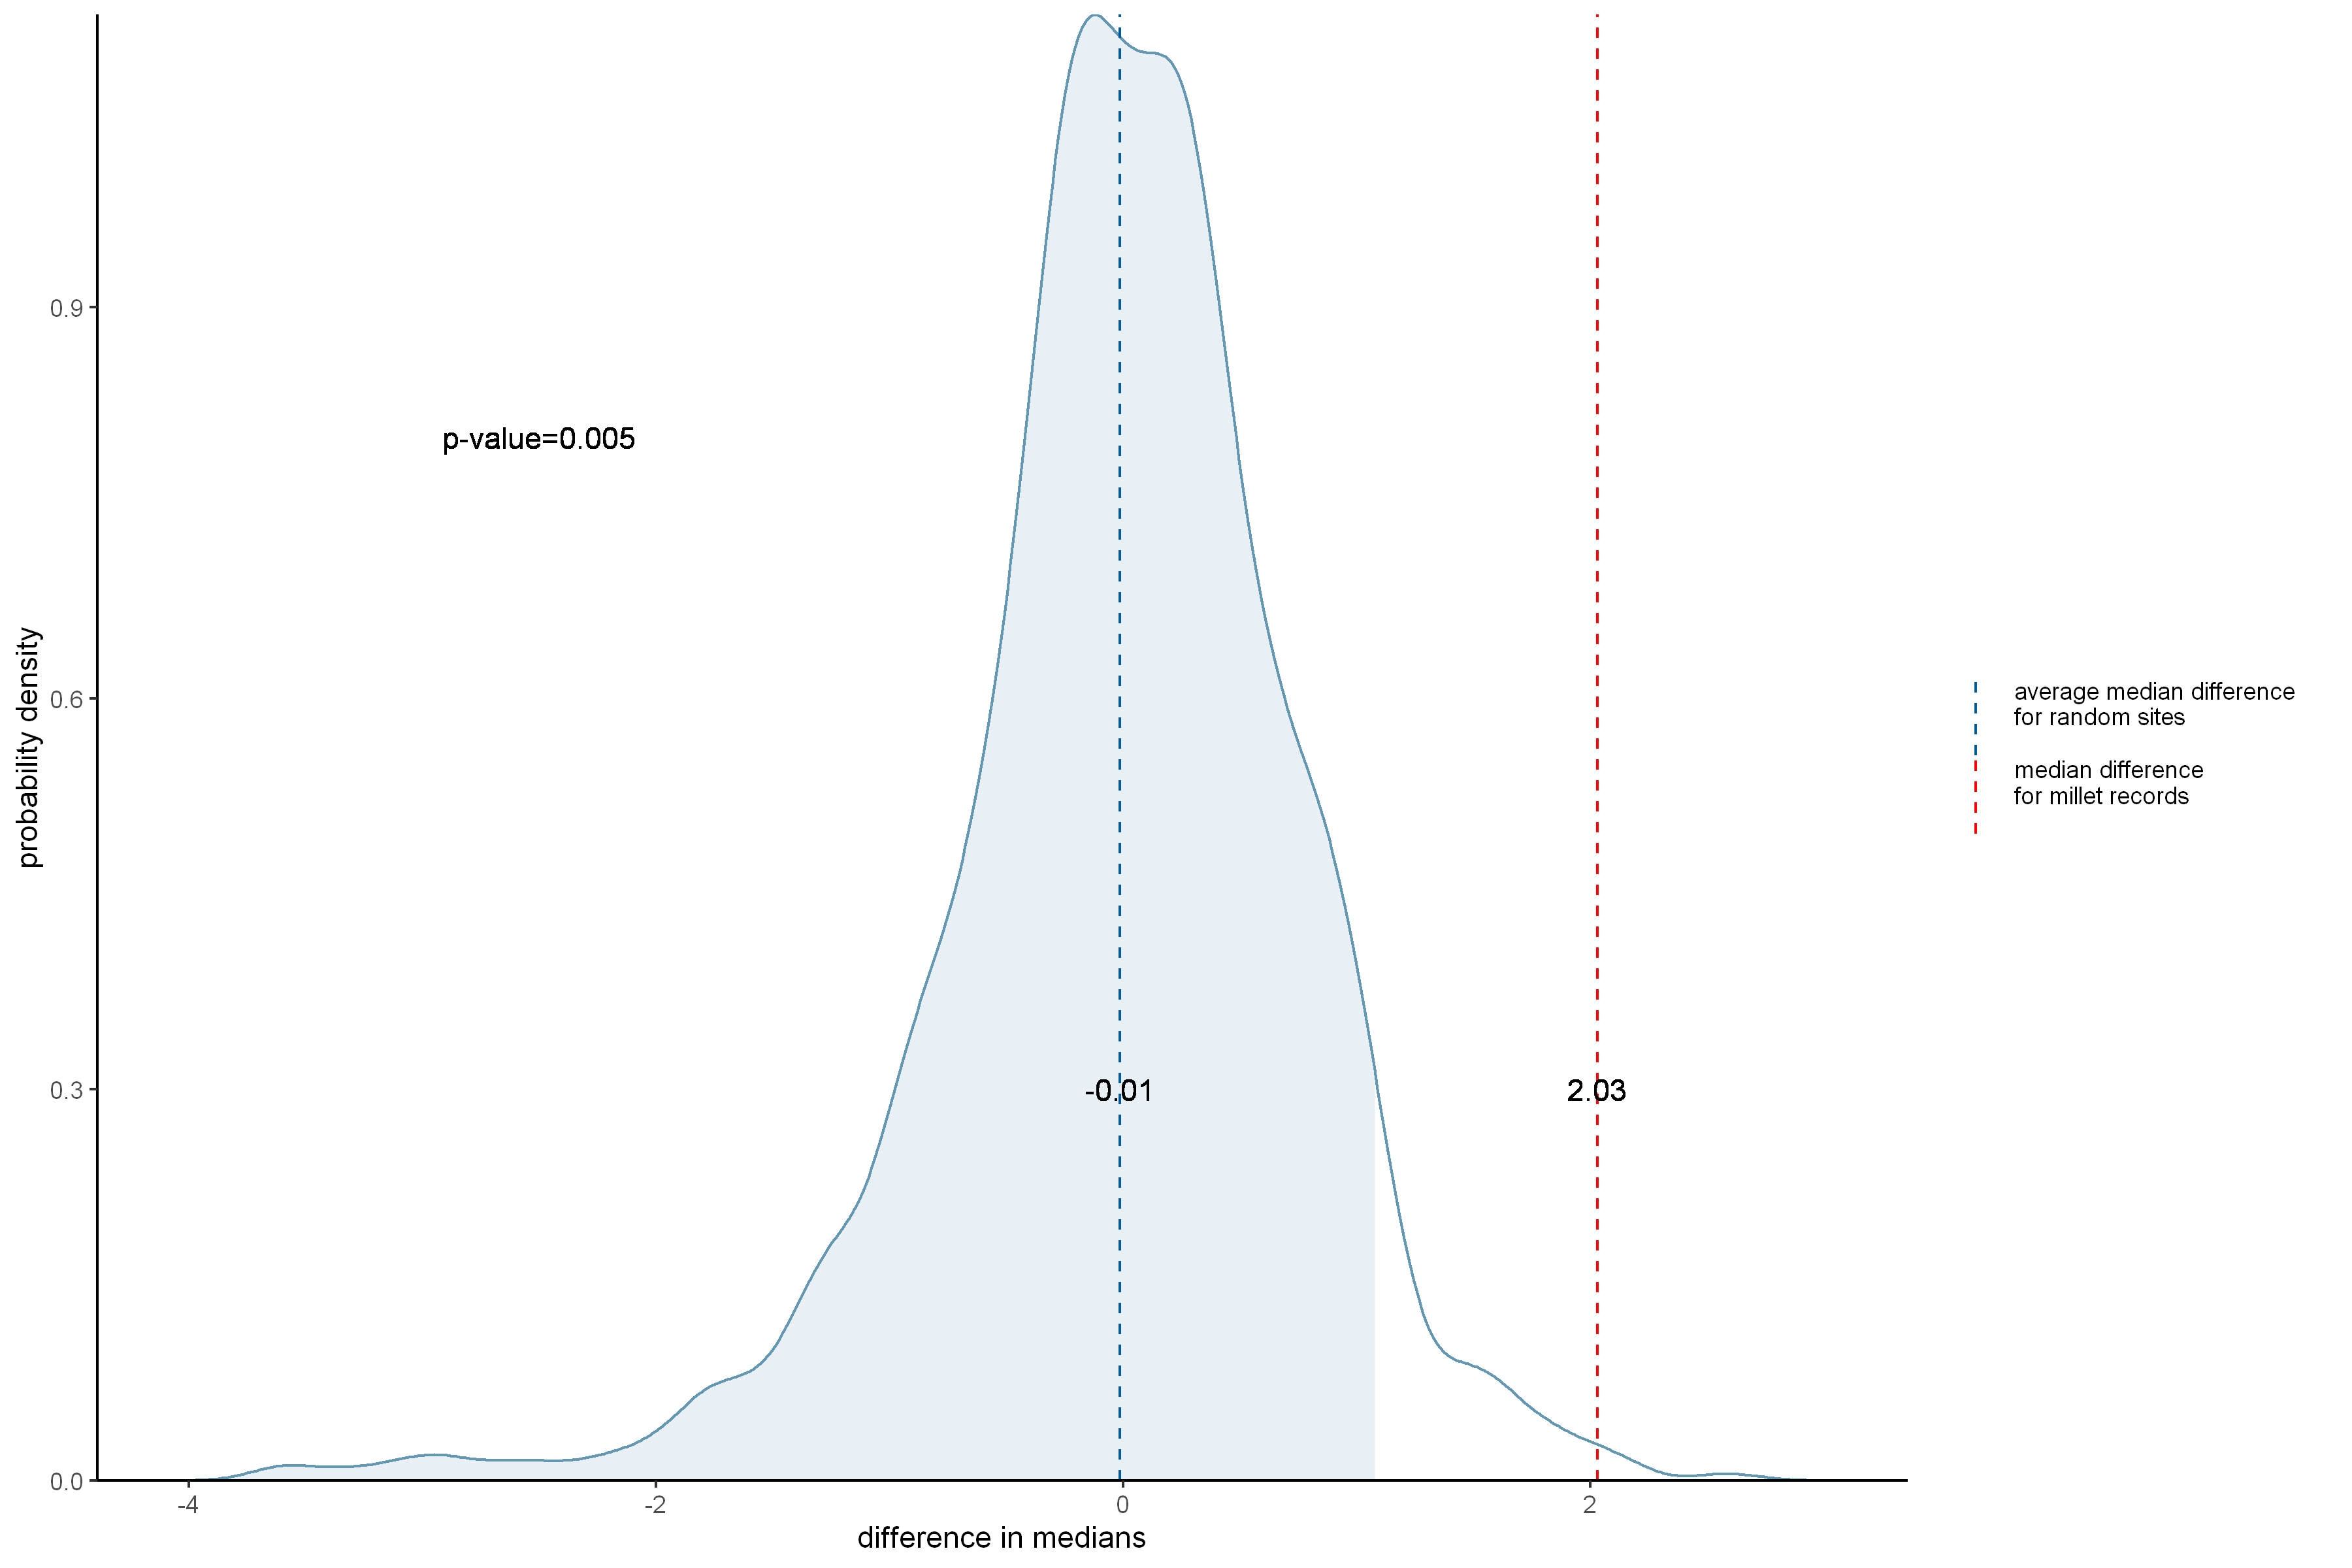

In [329]:
difference

In [332]:
save_plot(here("outputs","significance_test_example.png"),a,base_width = 12, base_height = 8,dpi=300)

In [331]:
a<-plot_grid(samples, difference, labels = "AUTO")

Picking joint bandwidth of 0.139



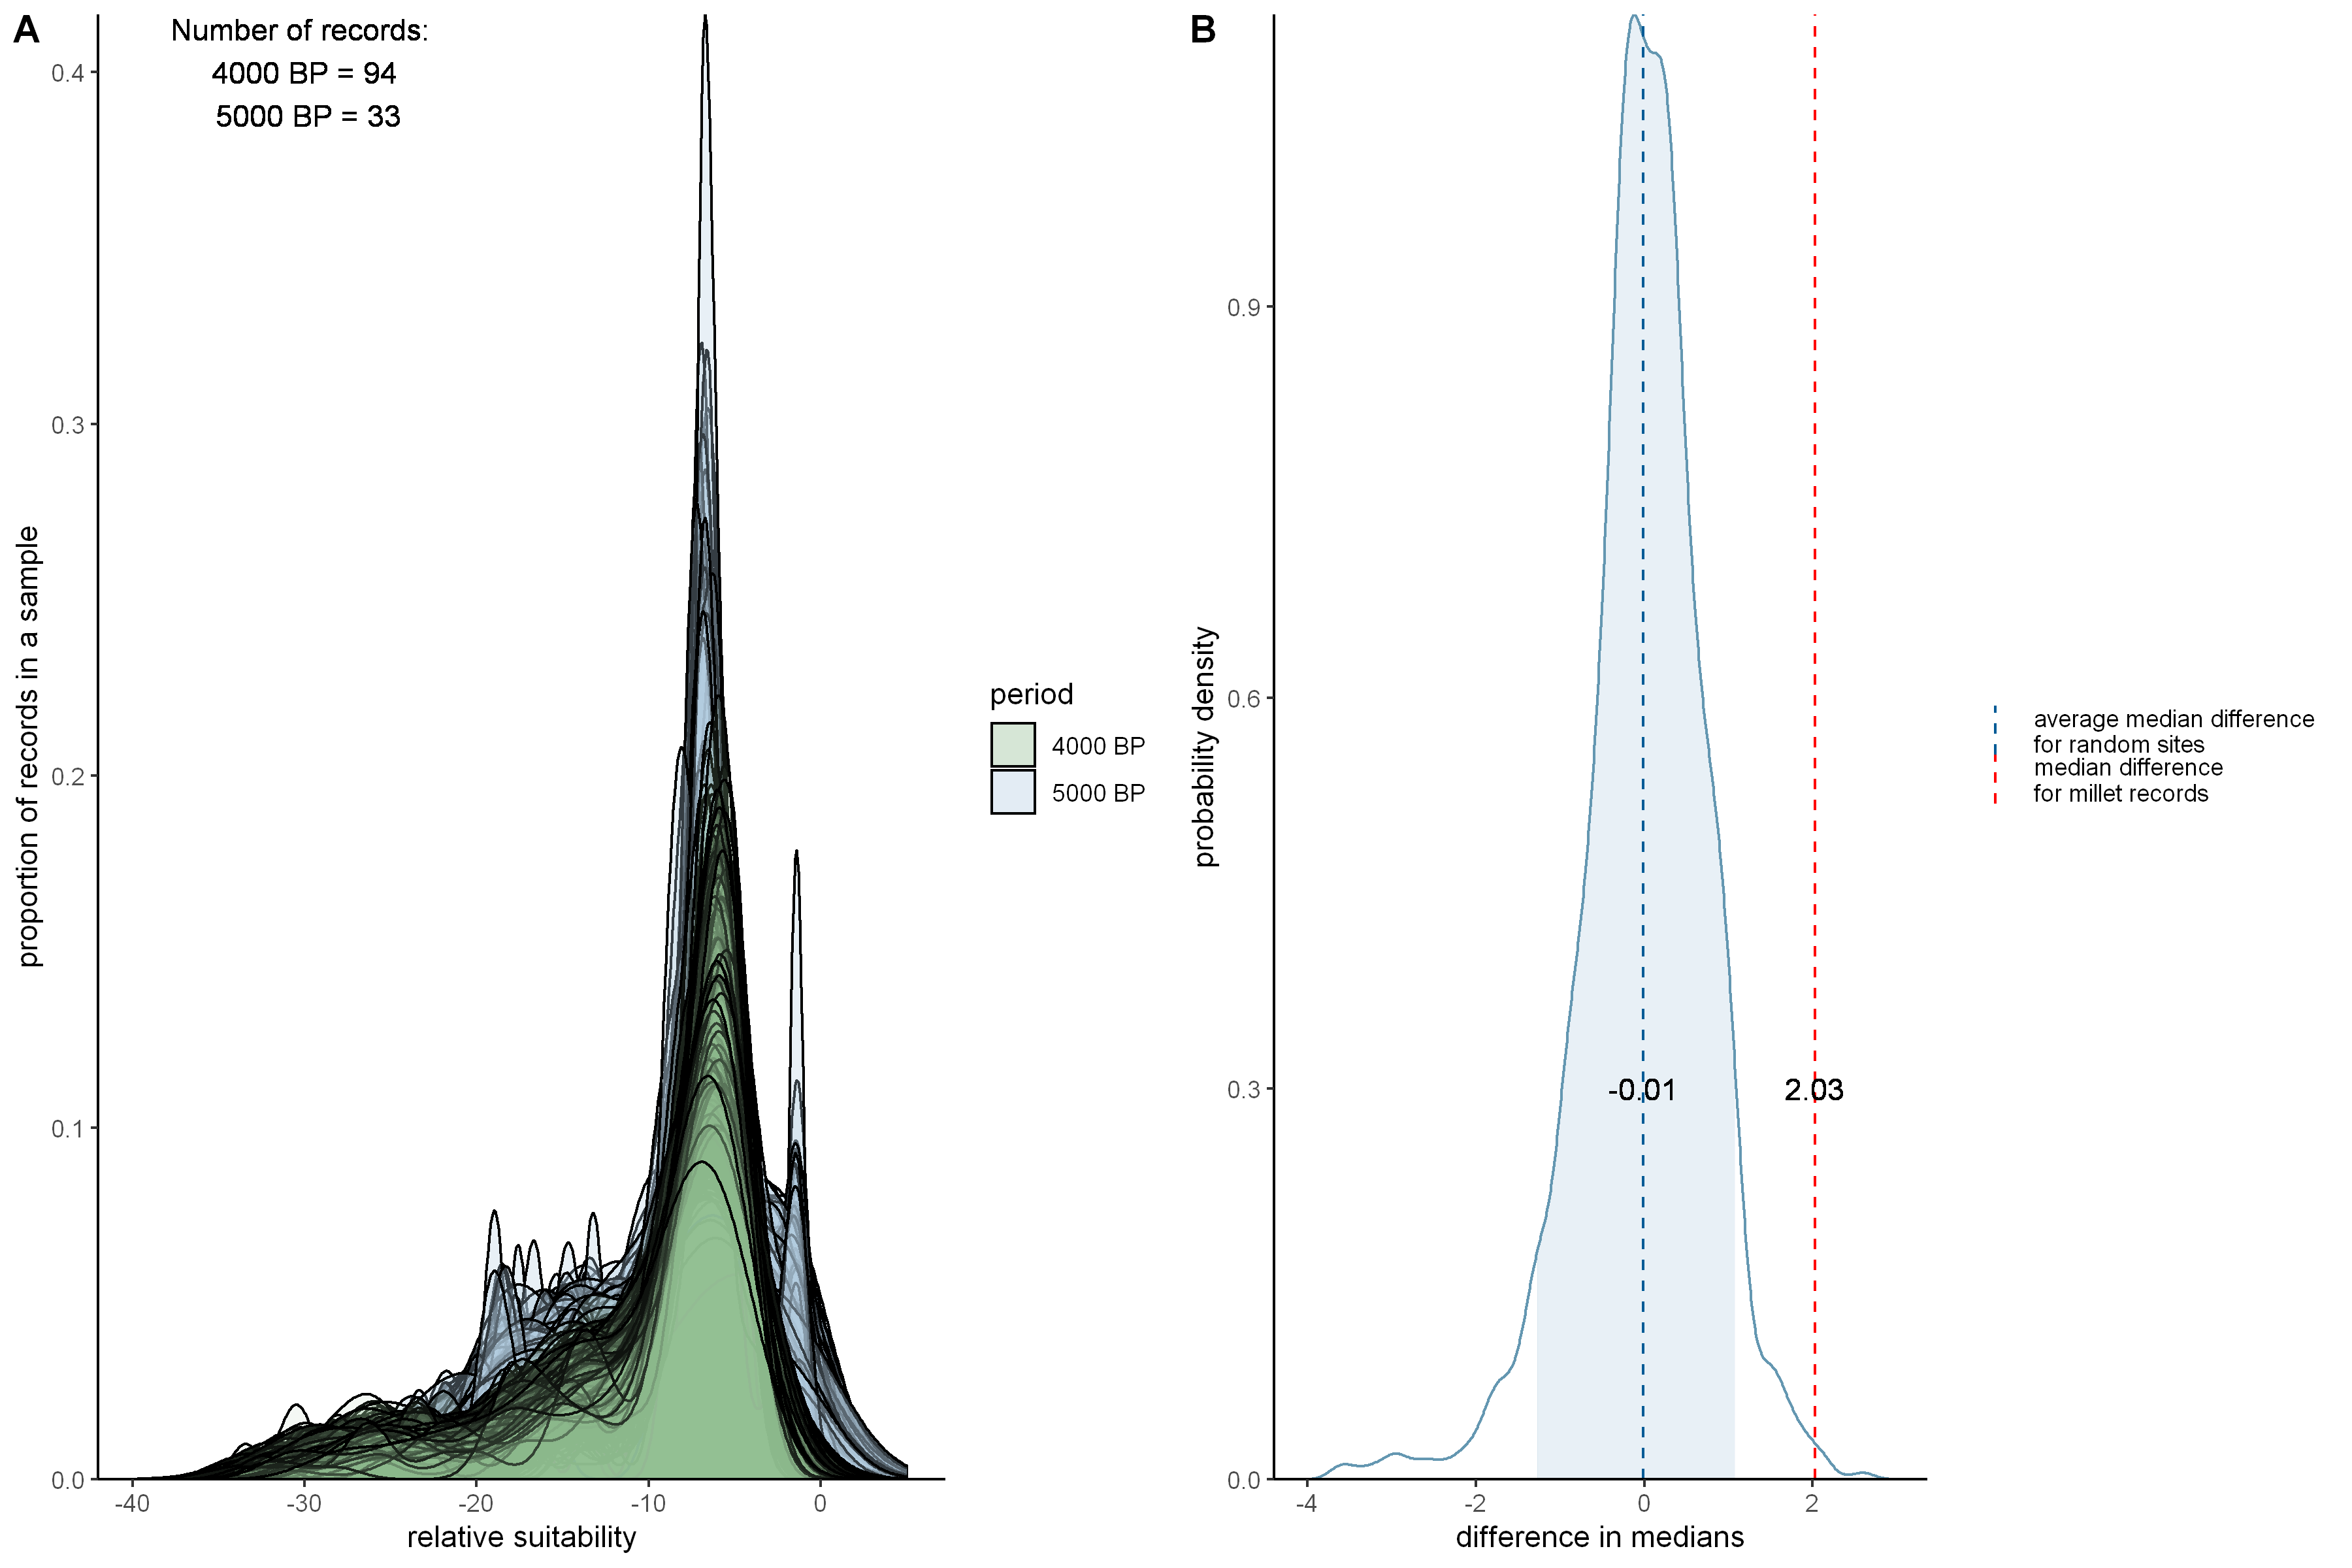

In [316]:
options(repr.plot.width=12,repr.plot.height=8,repr.plot.res=300)
a

In [38]:
clc=0.75
b=3.625
# for millet
b=4
mod=0.8

# for wheat

b=4.5
mod=0.6

# for barley
mod=1.2



In [1171]:
col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"),bias=b)


In [ ]:
 s<-ssizes[ssizes[crop]>=10,]
med<-aggregate(suitability[,paste(crop,"Mean",sep="")]~period,data=suitability, median)
med<-med[med$period %in% row.names(s),]
mat<-data.frame(matrix(ncol = nrow(med), nrow = nrow(med)),row.names=med$period)
pvalues<-data.frame(matrix(ncol = nrow(med), nrow = nrow(med)),row.names=med$period)
colnames(mat)<-med$period
colnames(pvalues)<-med$period

# Get the matrix of differences
for(i in 1:ncol(mat)){
    print (i)
    mat[,i]<-med[med$period==colnames(mat[i]),2]-med[,2]
}

write.csv(mat,here("outputs",paste(crop,"_diff_matrix.csv",sep="")))

for(i in 1:ncol(mat)){
    print(i)
    t1<-colnames(mat)[i]
    print(t1)
    for(j in 1:nrow(mat)){
        t2<-rownames(mat)[j]
        print(t2)
    
            diff<-summary[,grep(gsub(" BP","",t1),colnames(summary))]-summary[,grep(gsub(" BP","",t2),colnames(summary))]
            p=(sum(diff>mat[t2,t1])+1)/(1000+1)
            print(p)
            pvalues[t2,t1]<-p
        
    
    }
    write.csv(pvalues,here("outputs",paste(crop,"_pvalues_matrix.csv",sep="")))
    
  

}

  path2corrplot<-here("manuscript","Chapter6","Figs","Raster",paste(crop,"_corrplot.png",sep=""))
    #options(repr.plot.width=14.3,repr.plot.height=14.3,repr.plot.res=300)
    png(path2corrplot, units="cm", width=14.3*mod, height=14.3*mod, res=300,bg = "transparent")
    corrplot(as.matrix(pvalues), method="color", col=col(200),
         type="upper", addCoef.col = "black", # Add coefficient of correlation
         tl.col="black", tl.srt=45, #Text label color and rotation
         # Combine with significance
         sig.level = 0.05,insig = 'n',
         # hide correlation coefficient on the principal diagonal
         diag=FALSE,number.cex=0.6,tl.cex=clc,cl.cex=clc,is.corr=FALSE,number.digits = 3,cl.lim=c(0,1),mar=c(1,1,1,5)
         )
    dev.off()
 